In [1]:
import torch 
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

import matplotlib.pyplot as plt
import os

from typing import List,Tuple,Callable,Dict

from utility_functions import *
from dataset_dataloader import *
from variable_unet import *
from augmentation_class import *
from train_utility_functions import *

from ipywidgets import *

import numba

import pickle

#### load dataset

In [2]:
test_ds = SegDataset(root='test',sift=False,test=True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

#### Visualize images and masks

In [ ]:

# enable numba for faster implementation

# @numba.njit
def put_mask(mask,image):
    '''
    Objective
        return the image portion where the mask ==1
    
    Args
        mask : 2D numpy array (r,c)
        image: 2D numpy array
    '''
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if mask[r,c]==0 :
                image[r,c]=0
                
    return image


# %timeit put_mask(mask,img)

In [ ]:

@interact(index=IntSlider(min=0,max=len(test_dl)-1),continous_update=False)
def show_image(index,save=False):
    
    img = test_ds[index][0][0].numpy()
    mask = test_ds[index][1][0].numpy()
    mask = put_mask(mask,img.copy())
    
    plt.figure(figsize=(15,15))
    
    plt.subplot(1,2,1)
    plt.title('Input')
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title('Mask')
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    
    if save:
        plt.savefig(os.path.join('viz','data.svg'))

#### Test dataset

#### Visualize predictions

##### for variable batch

In [3]:

def dice_coeff(input, label):
    smooth = 1.
    iflat = input.contiguous().view(-1)
    lflat = label.contiguous().view(-1)
    intersection = (iflat * lflat).sum()
    
    return ((2. * intersection + smooth) / (iflat.sum() + lflat.sum() + smooth))

class dice_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, label):
        dice_val = dice_coeff(input, label)
        return 1 - dice_val

def postprocess_im(tensor: torch.Tensor ,th: float = 0.5):
    """
    1. Applies sigmoid layer to U-Net output
    2. Thresholds to certain value. 
    i.e.) Values lower than th = 0 / Values higher than th = 1
    """
    
    tensor_th = tensor.clone()
    tensor_th = sigmoid(tensor_th)
    tensor_th[tensor_th <= th] = 0
    tensor_th[tensor_th > th] = 1
    
    return tensor_th   


dice_score = []
sigmoid = nn.Sigmoid()


thisdir = os.path.join('models',  'variable batch size')
models_paths = []
loaded_model =None
test_input_transform = PreprocessAug(device=0, batch_size=1,crop_size=320,full_size=320,)

for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith(".tar"):
            models_paths.append(os.path.join(r, file))
            
@interact(path= models_paths,load=False)
def load_and_test_model(path,load=False):
    global loaded_model
    
    if load :
        loaded_model = variable_unet_class(in_channels=1,out_channels=1,init_filters=64,block_count=4,upsample=False)
        loaded_model.load_state_dict(torch.load(path))
        torch.autograd.set_grad_enabled(False)
        loaded_model.eval()
        loaded_model.cuda();
        print('model loaded.')
        
        dice_score = []
        
        for test_image,test_label in tqdm(test_ds):
            test_image_cuda,label_image_cuda = test_input_transform(test_image.float(),test_label.float(),training=False)
            label_prediction = postprocess_im(loaded_model(test_image_cuda))
            dice_score.append(dice_coeff(label_prediction,label_image_cuda).detach().cpu().numpy())
        
        
        print(f'Tested samples\t={len(dice_score)}\ndice score\t={np.mean(dice_score)}')

interactive(children=(Dropdown(description='path', options=('models\\variable batch size\\batch_16_params_3104…

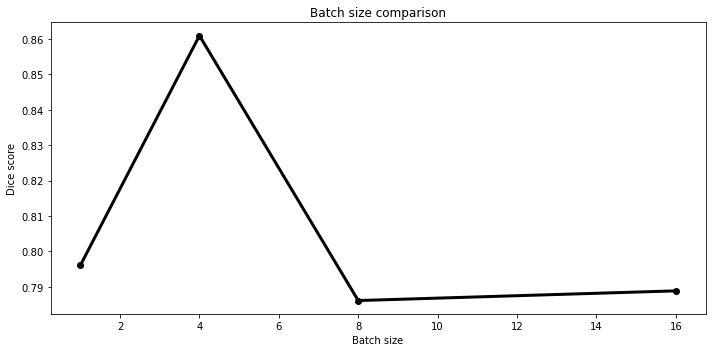

In [4]:
# variable batch experiement
variable_batch_dice_x = np.array([1,4,8,16])
variable_batch_dice_y = np.array([0.7960584759712219,0.8609088659286499,0.786126434803009,0.7888643741607666])

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.title.set_text(f'Batch size comparison')
ax1.plot(variable_batch_dice_x,variable_batch_dice_y,'-ok',linewidth=3)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylabel('Dice score', color='black')
ax1.set_xlabel('Batch size', color='black')

# ax2 = ax1.twinx()  
# ax2.set_ylabel('$MAE$', color='red')  
# ax2.plot(iterations, MAE_iterations,'-r',linewidth=3)
# ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.savefig(os.path.join('viz','batch.svg'))

In [5]:
thisdir = os.path.join('models',  'variable batch size')
models_paths = []
loaded_model =None
test_input_transform = PreprocessAug(device=0, batch_size=1,crop_size=320,full_size=320,)

for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith(".tar"):
            models_paths.append(os.path.join(r, file))

@interact(path= models_paths,load=False,index=IntSlider(min=0,max=len(test_dl)-1),continous_update=False,save=False)
def load_and_visualize_model(path,load=False,index=0,save=False):
    global loaded_model
    
    if load :
        loaded_model = variable_unet_class(in_channels=1,out_channels=1,init_filters=64,block_count=4,upsample=False)
        loaded_model.load_state_dict(torch.load(path))
        torch.autograd.set_grad_enabled(False)
        loaded_model.eval()
        loaded_model.cuda();
        print('model loaded.')
        
        dice_score = []
        
        img = test_ds[index][0][0].numpy()
        mask = test_ds[index][1][0].numpy()
        
        img_cuda,label_cuda = test_input_transform(torch.from_numpy(img).float(),torch.from_numpy(mask).float(),training=False)
        mask_pred = postprocess_im(loaded_model(img_cuda))
        dice_score = (dice_coeff(label_prediction,label_image_cuda).detach().cpu().numpy())
        
        
        plt.figure(figsize=(15,10))

        plt.subplot(1,3,1)
        plt.title('Input')
        plt.imshow(img,cmap='jet')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.title('True Mask')
        plt.imshow(mask,cmap='jet')
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.title('Predicted Mask')
        plt.imshow(mask_pred.cpu()[0,0],cmap='jet')
        plt.axis('off')
        
        if save:
            plt.savefig(os.path.join('viz','true_pred.pdf'))
    

NameError: name 'test_dl' is not defined

##### for variable filter size

In [6]:

def dice_coeff(input, label):
    smooth = 1.
    iflat = input.contiguous().view(-1)
    lflat = label.contiguous().view(-1)
    intersection = (iflat * lflat).sum()
    
    return ((2. * intersection + smooth) / (iflat.sum() + lflat.sum() + smooth))

class dice_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, label):
        dice_val = dice_coeff(input, label)
        return 1 - dice_val

def postprocess_im(tensor: torch.Tensor ,th: float = 0.5):
    """
    1. Applies sigmoid layer to U-Net output
    2. Thresholds to certain value. 
    i.e.) Values lower than th = 0 / Values higher than th = 1
    """
    
    tensor_th = tensor.clone()
    tensor_th = sigmoid(tensor_th)
    tensor_th[tensor_th <= th] = 0
    tensor_th[tensor_th > th] = 1
    
    return tensor_th   


dice_score = []
sigmoid = nn.Sigmoid()


thisdir = os.path.join('models',  'variable filter size')
models_paths = []
loaded_model =None
test_input_transform = PreprocessAug(device=0, batch_size=1,crop_size=320,full_size=320,)

for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith(".tar"):
            models_paths.append(os.path.join(r, file))

models_paths= sorted(models_paths)
            
@interact(path= models_paths,load=False)
def load_and_test_model(path,load=False):
    global loaded_model
    
    if load :
        
        init_filters = int(path.split('_')[-4])
        
        loaded_model = variable_unet_class(in_channels=1,out_channels=1,init_filters=init_filters,block_count=4,upsample=False)
        loaded_model.load_state_dict(torch.load(path))
        torch.autograd.set_grad_enabled(False)
        loaded_model.eval()
        loaded_model.cuda();
        print('model loaded.')
        
        dice_score = []
        
        for test_image,test_label in tqdm(test_ds):
            test_image_cuda,label_image_cuda = test_input_transform(test_image.float(),test_label.float(),training=False)
            label_prediction = postprocess_im(loaded_model(test_image_cuda))
            dice_score.append(dice_coeff(label_prediction,label_image_cuda).detach().cpu().numpy())
        
        
        count_params = lambda  model : sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f'Parameters \t={count_params(loaded_model)}')
        print(f'Tested samples\t={len(dice_score)}\ndice score\t={np.mean(dice_score)}')

interactive(children=(Dropdown(description='path', options=('models\\variable filter size\\init_filter_16_para…

In [ ]:
# variable batch experiement
variable_filter_dice_x = np.array([8,16,32,64])
variable_filter_dice_y = np.array([0.8376182913780212,0.8509801626205444,0.8448148965835571,0.8770840167999268])
variable_filter_dice_y_params = np.array([487145,1943761,7765409,31042369])

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.title.set_text(f'Initial filter size comparison')
ax1.plot(variable_filter_dice_x,variable_filter_dice_y,'-ok',linewidth=3)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylabel('Dice score', color='black')
ax1.set_xlabel('Initial filter size', color='black')
ax1.set_xticks(variable_filter_dice_x)

ax2 = ax1.twinx()  
ax2.set_ylabel('parameters count', color='red')  
ax2.plot(variable_filter_dice_x, variable_filter_dice_y_params,'-r',linewidth=3)
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.savefig(os.path.join('viz','filter.pdf'))

##### for variable block count


In [ ]:

def dice_coeff(input, label):
    smooth = 1.
    iflat = input.contiguous().view(-1)
    lflat = label.contiguous().view(-1)
    intersection = (iflat * lflat).sum()
    
    return ((2. * intersection + smooth) / (iflat.sum() + lflat.sum() + smooth))

class dice_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, label):
        dice_val = dice_coeff(input, label)
        return 1 - dice_val

def postprocess_im(tensor: torch.Tensor ,th: float = 0.5):
    """
    1. Applies sigmoid layer to U-Net output
    2. Thresholds to certain value. 
    i.e.) Values lower than th = 0 / Values higher than th = 1
    """
    
    tensor_th = tensor.clone()
    tensor_th = sigmoid(tensor_th)
    tensor_th[tensor_th <= th] = 0
    tensor_th[tensor_th > th] = 1
    
    return tensor_th   


dice_score = []
sigmoid = nn.Sigmoid()


thisdir = os.path.join('models',  'variable block count')
models_paths = []
loaded_model =None
test_input_transform = PreprocessAug(device=0, batch_size=1,crop_size=320,full_size=320,)

for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith(".tar"):
            models_paths.append(os.path.join(r, file))

models_paths= sorted(models_paths)
            
@interact(path= models_paths,load=False)
def load_and_test_model(path,load=False):
    global loaded_model
    
    if load :
        
        block_count = int(path.split('_')[-4])
        
        loaded_model = variable_unet_class(in_channels=1,out_channels=1,init_filters=4,block_count=block_count,upsample=False)
        loaded_model.load_state_dict(torch.load(path))
        torch.autograd.set_grad_enabled(False)
        loaded_model.eval()
        loaded_model.cuda();
        print('model loaded.')
        
        dice_score = []
        
        for test_image,test_label in tqdm(test_ds):
            test_image_cuda,label_image_cuda = test_input_transform(test_image.float(),test_label.float(),training=False)
            label_prediction = postprocess_im(loaded_model(test_image_cuda))
            dice_score.append(dice_coeff(label_prediction,label_image_cuda).detach().cpu().numpy())
        
        
        count_params = lambda  model : sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f'Parameters \t={count_params(loaded_model)}')
        print(f'Tested samples\t={len(dice_score)}\ndice score\t={np.mean(dice_score)}')

In [ ]:
# variable batch experiement
variable_block_dice_x = np.array([8,16,32,64])
variable_block_dice_y = np.array([0.731446385383606,0.7391102313995361,0.41931119561195374,0.41931119561195374])
variable_block_dice_y_params = np.array([122389,488149,1948757,7786325])

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.title.set_text(f'Block count comparison')
ax1.plot(variable_block_dice_x,variable_block_dice_y,'-ok',linewidth=3)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylabel('Dice score', color='black')
ax1.set_xlabel('Block', color='black')
ax1.set_xticks(variable_block_dice_x)

ax2 = ax1.twinx()  
ax2.set_ylabel('parameters count', color='red')  
ax2.plot(variable_block_dice_x, variable_block_dice_y_params,'-r',linewidth=3)
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.savefig(os.path.join('viz','block.pdf'))